In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
from sklearn import model_selection, metrics

from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa

from scikeras.wrappers import KerasRegressor
from keras import layers



import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In this script I will use autoencoders on Microbial relative abundance data.  
1: Read Microbial abundance data  
    - Split into train and test  
    - Transform?  
2: Fit an audoencoeder  
3: Check error  


In [8]:
def Filter_prevalence(x, Threshold=0.2, Mean_abundance_threshold = 0 ):
    Prevalence = len(x[x>0])/len(x)
    Prev_filter = Prevalence > Threshold
    Abundance_filter = np.mean(x) > Mean_abundance_threshold
    return(Prev_filter and Abundance_filter)
def Back_to_100(x):
    return(x / sum(x))
def Pseudocount(d):
    p = min(d[d>0]) / 1.5
    d2 = d + p 
    return(d2)

def CLR_norm(x):
    """
    Centered Log Ratio
    Aitchison, J. (1982). 
    The statistical analysis of compositional data. 
    Journal of the Royal Statistical Society: 
    Series B (Methodological), 44(2), 139-160.
    0 --> Apply function per column (bug)
    1 --> Apply function per row (Participant)
    """
    d = np.array(x)
    d = Pseudocount(d)
    d = pd.DataFrame(d.astype(float), columns=list(x.columns))
    step1_1 = d.apply(np.log, axis = 0)
    step1_2 = step1_1.apply(np.average, axis = 1)
    step1_3 = step1_2.apply(np.exp)
    step2 = d.divide(step1_3, axis = 0)
    step3 = step2.apply(np.log, axis = 1)
    return(step3)

def Microbiom_preprocess(Microbiome_table, Columns_remove= ["UNKNOWN","ID"], CLR=False ):
    #Removal of UNKNOWN and IDs
    Microbiome_table = Microbiome_table.drop(Columns_remove  , axis=1)
    
    #Remove taxa in low abundance, keep only species
    Keep_columns = [ "s__" in i for i in Microbiome_table.columns ]
    Sp_table = Microbiome_table.loc[:, Keep_columns]

    #Filter on prevalence
    Keep_species = Sp_table.apply(Filter_prevalence, axis=0) #0 is columns
    if CLR == True:
        Sp_table = CLR_norm(Sp_table)
        Sp_table = Sp_table.loc[:, Keep_species]
    else:
        #Recalculate to 100
        Sp_table = Sp_table.loc[:, Keep_species]
        Sp_table = Sp_table.apply(Back_to_100, axis=1) #1 is rows

    return(Sp_table)
def Pearson(X1, X2):
    Rho = np.cov(X1,X2) / (np.std(X1) * np.std(X2) )
    return(float(Rho[0,1]))

def Plot_history(Result):
    #Plot loss
    fig, ax = plt.subplots(figsize=(16,9), dpi=300)
    plt.title(label='Model Loss by Epoch', loc='center')
    ax.plot(Result.history['loss'], label='Training Data', color='black')
    ax.plot(Result.history['val_loss'], label='Test Data', color='red')
    ax.set(xlabel='Epoch', ylabel='Loss')
    plt.xticks(ticks=np.arange(len(Result.history['loss'])), labels=np.arange(1, len(Result.history['loss'])+1))
    plt.legend()
    plt.show()
def Standarize(X):
    XNormed = (X - X.mean())/(X.std())
    return(XNormed)
def Get_Mean_Correlation(X, X_predict, Print="No"):
    Rhos = []
    for Sp_index in range(len(X.columns)):
        df = pd.DataFrame({"Prediction": list(np.array(X_predict)[:,Sp_index]), "Target": list(X.iloc[:,Sp_index])})
        Rho = Pearson(df["Prediction"], df["Target"])
        Name = ( list(X.columns)[Sp_index] ).split("|")[-1]
        Mean_abundance = np.mean(df["Target"])
        if Print == "Yes":
            print(Rho, Name, Mean_abundance)
        Rhos.append(Rho)
    print("Mean rho: " + str(np.nanmean(Rhos)) + " || Median rho: " +  str(np.nanmedian(Rhos)) )
def Check_performance(X, Y, autoencoder, With_Std=True, Print="No" ):
    print("Wihtout transformation")
    Get_Mean_Correlation(Y, X)
    print("With transformation")
    if With_Std == True:
        X = Standarize(X)
        Y = Standarize(Y)
    Y_predict = autoencoder.predict(X)
    Get_Mean_Correlation(Y, Y_predict, Print)
    
    MSE = metrics.mean_squared_error(np.array(Y), np.array(Y_predict) )
    MSE_before = metrics.mean_squared_error(np.array(Y), np.array(X) )
    print("MSE before vs after transfromation")
    print(MSE_before, MSE)
    
def Simplify_name(X):
    r = []
    X = list(X)
    for x in X:
        r.append(x.split("|")[-1])
    return(r)
class LossBrayCurtis(keras.losses.Loss):
    #I think this is wrong, the denominator seems right, but the numerator does not take into account the 0s, and is meant to take the min between both, not the difference
    def __init__(self, y_true_transformer, y_pred_transformer):
        super(LossBrayCurtis, self).__init__(name='bray_curtis')
        self.y_true_transformer = y_true_transformer
        self.y_pred_transformer = y_pred_transformer

    def call(self, y_true, y_pred):
        if self.y_true_transformer is not None:
            y_true = self.y_true_transformer(y_true)
        if self.y_pred_transformer is not None:
            y_pred = self.y_pred_transformer(y_pred)
        diff = tf.math.abs(y_true - y_pred)
        sum = tf.math.abs(y_true + y_pred)
        value = tf.reduce_sum(diff, axis=-1) / tf.reduce_sum(sum, axis=-1)
        return value

class MakeLoss():
    def __init__(self, loss_fn, true_fn, pred_fn):
        self.loss_fn = loss_fn
        self.true_fn = true_fn
        self.pred_fn = pred_fn

    def make(self):
        true_fn = self.true_fn() if self.true_fn is not None else None
        pred_fn = self.pred_fn() if self.pred_fn is not None else None
        return self.loss_fn(true_fn, pred_fn)
class Percentage(layers.Layer):

    def __init__(self, epsilon=1E-6):
        super(Percentage, self).__init__(name='percentage')
        self.epsilon = epsilon

    def build(self, input_shape):
        super(Percentage, self).build(input_shape)

    def call(self, x, **kwargs):
        epsilon = tf.constant(self.epsilon)
        x_sum = tf.math.reduce_sum(x, axis=-1, keepdims=True)
        elements = tf.shape(x)[-1]
        x_sum += epsilon * tf.cast(elements, dtype=tf.float32)
        percent = tf.math.divide(x, x_sum, name='percentage')
        percent += epsilon
        return percent
def Ordination(Predicted, Microbiome_comparison, Metadata, CLR = False, Standar = False, To_hundred=True,  metric="braycurtis"):
    if CLR == False:
        Predicted[Predicted<0] = 0

    #### All data
    Microbiome_comparison_all = Microbiome_comparison.loc[:, Microbiome_comparison_FSK_process.columns ]
    
    if To_hundred == True and CLR == False:
        Microbiome_comparison_all = Back_to_100( np.array(Microbiome_comparison_all) )
        Microbiome_comparison_all = pd.DataFrame(Microbiome_comparison_all, columns= list(Microbiome_comparison_FSK_process.columns)  )
        Predicted = Back_to_100(Predicted)
    
    if CLR == True:
        #If CLR...
        Microbiome_comparison_all = CLR_norm(Microbiome_comparison_all)
    if Standar == True:
        #If normalized...
        Microbiome_comparison_all = Standarize(Microbiome_comparison_all)
    
    To_Add = pd.DataFrame(Predicted, columns = list(Microbiome_comparison_all.columns))
    print(To_Add.shape, Microbiome_comparison_all.shape )
    Microbiome_comparison_all = Microbiome_comparison_all.append( To_Add )
    #Microbiome_comparison_all = pd.concat([Microbiome_comparison_all, To_Add], axis=0)
    
    
    print(Microbiome_comparison_all.shape)
    
    ID_prediction = list(Metadata["Identifier"])
    ID_prediction.extend( list(Metadata[Metadata["Extraction.protocol"] == "FSK"]["Identifier"]) )
    Individual_ID_prediction = list(Metadata["ID"])
    Individual_ID_prediction.extend( list(Metadata[Metadata["Extraction.protocol"] == "FSK"]["ID"]))
    Protocol = list(Metadata["Extraction.protocol"])
    Protocol_prediction = list(pd.Series(["Predicted_APK"]).repeat(Predicted.shape[0]))

    Protocol.extend(Protocol_prediction)

    BC = beta_diversity(metric,Microbiome_comparison_all)
    PCs = pcoa(BC)
    
    Proportion = PCs.proportion_explained
    PC_values =  PCs.samples
    P1 = str(100*round(Proportion.iloc[0], 3)) ; P2 = str(100*round(Proportion.iloc[1],3))
    
    print(len(ID_prediction), len(Protocol), PC_values.shape)
    DF_PCA = pd.DataFrame( {'ID' : ID_prediction , 'PC1' : list(PC_values.iloc[:,0]),
                          'PC2' : list(PC_values.iloc[:,1]), 'Protocol' : Protocol} ) 

    sns.set_theme(style="ticks")
    fig =plt.plot()
    sns.scatterplot(x="PC1", y="PC2", hue=Protocol, data=DF_PCA).set(title="{m}_PCoA".format(m=metric))
    plt.xlabel("PC1({P})%".format(P=P1), fontsize = 13)
    plt.ylabel("PC2({P})%".format(P=P2), fontsize = 13)
    
    Microbiome_comparison_all.columns = Simplify_name(Microbiome_comparison_all.columns)
    
    DF_PCA =DF_PCA.reset_index(drop=True)
    Microbiome_comparison_all = Microbiome_comparison_all.reset_index(drop=True)
    
    DF_PCA = pd.concat([DF_PCA, Microbiome_comparison_all], axis=1)
    return(DF_PCA)


In [9]:
#Prepare Metadata
Metadata = pd.read_csv("Data_Asier/Protocol_comparison_metadata_table.txt", delimiter="\t")
Metadata["ID"] = np.nan
Metadata.ID[0:453] = Metadata.Identifier[0:453]
Metadata.ID[453:745] = [ str(i) for i in range(0,292) ]
Metadata.ID[745:1198] = Metadata.Identifier[0:453]
Metadata.ID[1198:1490] = [ str(i) for i in range(0,292) ]
Metadata = Metadata.sort_values(by=['ID'])


/var/folders/nf/9wry_8qs6gl5r51wp8466mvm0000gn/T/ipykernel_1428/3140703468.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Metadata.ID[0:453] = Metadata.Identifier[0:453]


In [10]:
#Prepare microbiome data
Microbiome_comparison = pd.read_csv("Data_Asier/Protocol_comparison_metaphlan3_species_table.txt", delimiter="\t")
Microbiome_comparison = Microbiome_comparison.drop("Unnamed: 0", axis=1)

Microbiome_comparison = Microbiome_comparison.T
Microbiome_comparison.columns = Microbiome_comparison.iloc[0,:]
Microbiome_comparison = Microbiome_comparison.iloc[1:,:]

Microbiome_comparison.index.name = 'Identifier'
Microbiome_comparison.reset_index(inplace=True)

Microbiome_comparison = Microbiome_comparison.merge( Metadata[["Identifier", "ID", "Cohort", "Extraction.protocol" ]], on='Identifier', how='left')
Microbiome_comparison = Microbiome_comparison.sort_values(by=['ID'])



In [11]:
Do_CLR = False #Change for CLR/ No clr
 
#Slice data by cohort (and get some held-out)
Info = ["ID",  "Extraction.protocol" , "Cohort"]
#print(Microbiome_comparison[ Info ])

#1. Split by protocol
Microbiome_comparison_FSK =  Microbiome_comparison[Microbiome_comparison["Extraction.protocol"] == "FSK" ]
Microbiome_comparison_APK =  Microbiome_comparison[Microbiome_comparison["Extraction.protocol"] == "APK" ]
#2. Process the data and remove none-abundant species
Microbiome_comparison_FSK_process = Microbiom_preprocess(Microbiome_comparison_FSK, Info,CLR=Do_CLR)
Microbiome_comparison_APK_process = Microbiom_preprocess(Microbiome_comparison_APK, Info, CLR=Do_CLR)

Keep_species = list(set(Microbiome_comparison_FSK_process.columns) & set(Microbiome_comparison_APK_process.columns))

Microbiome_comparison_FSK_process = Microbiome_comparison_FSK_process[Keep_species]
Microbiome_comparison_APK_process = Microbiome_comparison_APK_process[Keep_species]

print("Complete FSK", Microbiome_comparison_FSK_process.shape)
print("Complete APK", Microbiome_comparison_APK_process.shape)


#3. Split by cohort

Microbiome_comparison_LLD_FSK = Microbiome_comparison_FSK_process[list(Microbiome_comparison_FSK.Cohort == "LLD")]
Microbiome_comparison_500FG_FSK = Microbiome_comparison_FSK_process[list(Microbiome_comparison_FSK.Cohort == "500FG")]

Microbiome_comparison_LLD_APK = Microbiome_comparison_APK_process[list(Microbiome_comparison_APK.Cohort == "LLD")]
Microbiome_comparison_500FG_APK = Microbiome_comparison_APK_process[list(Microbiome_comparison_APK.Cohort == "500FG")]

print("500FG FSK", Microbiome_comparison_500FG_FSK.shape)
print("500FG APK",Microbiome_comparison_500FG_APK.shape)

print("LLD FSK", Microbiome_comparison_LLD_FSK.shape)
print("LLD APK",Microbiome_comparison_LLD_APK.shape)


#Get held-out data 500FG
#Add ids to track which samples were used for training and which for testing
Microbiome_comparison_500FG_FSK["ID"] = list(Microbiome_comparison_FSK[Microbiome_comparison_FSK.Cohort == "500FG"].Identifier)
X_train_i, X_test_i, Y_train, Y_test = model_selection.train_test_split(Microbiome_comparison_500FG_FSK, Microbiome_comparison_500FG_APK ,test_size=0.2, random_state=42)
X_train = X_train_i.drop("ID", axis=1) ; X_test = X_test_i.drop("ID", axis=1)



Complete FSK (745, 100)
Complete APK (745, 100)
500FG FSK (453, 100)
500FG APK (453, 100)
LLD FSK (292, 100)
LLD APK (292, 100)


/var/folders/nf/9wry_8qs6gl5r51wp8466mvm0000gn/T/ipykernel_1428/1139496033.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Microbiome_comparison_500FG_FSK["ID"] = list(Microbiome_comparison_FSK[Microbiome_comparison_FSK.Cohort == "500FG"].Identifier)


In [12]:
print(X_train.shape) ; print(X_test.shape) ; print(Y_train.shape) ; print(Y_test.shape)
mape = keras.losses.MeanAbsolutePercentageError(reduction=tf.keras.losses.Reduction.SUM)
Bray = MakeLoss(LossBrayCurtis, Percentage, None).make()

(362, 100)
(91, 100)
(362, 100)
(91, 100)


In [13]:
def CorrLoss(y_true, y_pred):
        x = pd.DataFrame(y_true).reset_index(drop=True)
        x2 = pd.DataFrame(y_pred).reset_index(drop=True)
        x2.columns = x.columns
        diff = float(x.corrwith(x2, drop=True).mean())
        return diff

def build_model3(latent_dim=90, activation=None,dropout=0.25, l1=0.0001):
    model = tf.keras.Sequential()
    model.add( keras.Input(100) )
    model.add(tf.keras.layers.Dense(latent_dim, activation= activation))
    model.add( layers.Dropout(dropout) )
    model.add(layers.Dense(100, activation="linear", kernel_initializer='glorot_uniform', activity_regularizer=keras.regularizers.L1(l1)))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=[Bray])
    return(model)

def build_model2(num_layer=1, layer_nodes=90,  l1=0.0001, l2=0.0001, dropout=0.25, latent_dim=60, activation_middle="linear", activation_layers="relu" ):
    reg = tf.keras.regularizers.L1L2(l1, l2)    
    #Encoder
    model = tf.keras.Sequential()
    model.add( keras.Input(100) )
    for l in range(num_layer):
        model.add(tf.keras.layers.Dense(layer_nodes, activation=activation_layers, kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg))
        model.add( layers.Dropout(dropout) )
    model.add(layers.Dense(units=latent_dim, activation=activation_middle,  kernel_initializer='glorot_uniform'))   
    for l in range(num_layer):
        model.add(tf.keras.layers.Dense(layer_nodes, activation=activation_middle, kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg ))
        model.add( layers.Dropout(dropout) )    
    model.add(layers.Dense(100, activation="linear", kernel_initializer='glorot_uniform'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=[Bray])
    return(model)
    
def CrossValidation_Train(num_cv=5, Patience=40):
    print("Defining hyperparameter space")
    _l1_lambda = np.logspace(-4,-2,50)
    _l2_lambda = np.logspace(-4,-1,10)
    _num_layer = [1,2,3]
    _layer_nodes = [90, 100]
    _hidden_dim = [60, 80, 90]
    _dropout = [0, 0.05, 0.1]
    
    params=dict(model__l1=_l1_lambda, model__l2=_l2_lambda, model__num_layer=_num_layer,
                model__layer_nodes = _layer_nodes, model__dropout=_dropout, model__latent_dim =  _hidden_dim, activation_middle=[None, "relu"], activation_layers=[None, "relu"] )
    
    #params=dict(model__latent_dim = _hidden_dim, model__activation = [None], model__l1=[0.0001,0], model__dropout=_dropout  )

    es_cb = tf.keras.callbacks.EarlyStopping('val_loss', patience=Patience, restore_best_weights=True)    
    
    
    print("Defining the loss function to compare models (Mean correlation between predictions and real values)")
    scorer =metrics.make_scorer(CorrLoss,greater_is_better=True)

    print("Defining model. Keras regressor.")
    model = KerasRegressor(model=build_model2, verbose=False, epochs=1000,batch_size=65, callbacks=[es_cb], validation_split=0.25 )

    print("Defining randomized search in the hyperparameter space")
    #rscv = model_selection.RandomizedSearchCV(estimator = model, param_distributions=params, cv=5, n_iter=20, scoring=scorer, n_jobs=1)
    rscv = model_selection.GridSearchCV(estimator = model, param_grid=params, cv=5, scoring=scorer) #scoring='explained_variance', 'r2' , 'neg_mean_squared_error'

    
    print("Fitting model")
    rscv_results = rscv.fit(Microbiome_comparison_500FG_FSK.drop("ID", axis=1), Microbiome_comparison_500FG_APK )
    print("Retrieving best parameters")
    best_params = rscv_results.best_params_
    
    print('Best score is: {} using {}'.format(rscv_results.best_score_, best_params))

    return(rscv_results, best_params)


rscv_results, best_params = CrossValidation_Train()    

Defining hyperparameter space
Defining the loss function to compare models (Mean correlation between predictions and real values)
Defining model. Keras regressor.
Defining randomized search in the hyperparameter space
Fitting model


ValueError: Invalid parameter activation_layers for estimator KerasRegressor.
This issue can likely be resolved by setting this parameter in the KerasRegressor constructor:
`KerasRegressor(activation_layers=None)`
Check the list of available parameters with `estimator.get_params().keys()`

In [14]:
#rscv_results.cv_results_
Check_performance(Microbiome_comparison_LLD_FSK, Microbiome_comparison_LLD_APK, With_Std=True, autoencoder=rscv_results )
Predicted = rscv_results.predict(Microbiome_comparison_FSK_process)
Data_save = Ordination(Predicted, Microbiome_comparison, Metadata, CLR = Do_CLR, Standar = False, metric="braycurtis")
rscv_results.cv_results_


NameError: name 'rscv_results' is not defined

In [15]:
class Shallow_Autoencoder(keras.Model):
  def __init__(self, latent_dim, l1=0.1, dropout=0.3):
    super(Shallow_Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      keras.Input(100),
      layers.Dense(latent_dim, kernel_initializer='glorot_uniform', activation=None,
      activity_regularizer=keras.regularizers.L1(0.0001))  ]) #Latent activation can be 'relu' or None
    
    self.decoder = tf.keras.Sequential([
      layers.Dropout(dropout),
      layers.Dense(100, kernel_initializer='glorot_uniform', activation=None), #Output activation, can be None, Sigmoid
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

class Autoencoder(keras.Model):
  def __init__(self, latent_dim, num_layer=1, layer_nodes=80, l1=0.0001, l2=0.0001, dropout=0.25 ):
    super(Autoencoder, self).__init__()
    
    reg = tf.keras.regularizers.L1L2(l1, l2)
    self.latent_dim = latent_dim   
    
    #Encoder
    self.encoder = tf.keras.Sequential()
    self.encoder.add( keras.Input(100) )
    for l in range(num_layer):
        self.encoder.add(tf.keras.layers.Dense(layer_nodes, activation='relu', kernel_regularizer=reg, bias_regularizer=reg, name="fc" + str(l)))
        self.encoder.add( layers.Dropout(dropout) )
    self.encoder.add(layers.Dense(units=latent_dim, activation='relu',  kernel_initializer='glorot_uniform'))                 
    #Decoder
    self.decoder = tf.keras.Sequential()
    for l in range(num_layer):
        self.decoder.add(tf.keras.layers.Dense(layer_nodes, activation='relu', kernel_regularizer=reg, bias_regularizer=reg, name="fc" + str(l)))
        self.decoder.add( layers.Dropout(dropout) )    
    self.decoder.add(layers.Dense(100, activation="linear", kernel_initializer='glorot_uniform'))
    

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [19]:
###Select the size of the encoder
encoding_dim = 60 #Number of layers in the latent space
autoencoder = Shallow_Autoencoder(encoding_dim, l1=0.1, dropout=0.3 )
autoencoder = Autoencoder(num_layer=2,layer_nodes= 90, latent_dim= 60, l2= 0.00021544346900318845,
                         l1= 0.00012067926406393288, dropout=0)

 
def Train_f(autoencoder, Train, Test, epochs=10000, batch_size=65, With_Std=True, loss_f="mse", Patience=40 ):
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=[loss_f])
    es_cb = tf.keras.callbacks.EarlyStopping('val_loss', patience=Patience, restore_best_weights=True)    
    X_train = Train[0] ; Y_train = Train[1]
    X_test = Test[0] ; Y_test = Test[1]
    
    if With_Std == True:
        X_train = Standarize(X_train); X_test = Standarize(X_test)
        Y_train = Standarize(Y_train); Y_test = Standarize(Y_test)
        
    history = autoencoder.fit(X_train, Y_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, Y_test), callbacks=[es_cb] ) 
        
        
    return(history)

#Optimize autoencoder
#Train = (X_train, X_train) ; Test = (X_test, X_test)

#Optimize DAU
Train = (X_train, Y_train) ; Test = (X_test, Y_test)

#Use whole data DAU
X_train2, X_test2, Y_train2, Y_test2 = model_selection.train_test_split(Microbiome_comparison_FSK_process,Microbiome_comparison_APK_process  ,test_size=0.2, random_state=42)
Train = (X_train2, Y_train2) ; Test = (X_test2, Y_test2)

#Use whole data AU
#Train = (X_train2, X_train2) ; Test = (X_test2, X_test2)


history = Train_f(autoencoder, Train, Test, With_Std=False, loss_f = Bray ) #mse
#history2 = Train_f(autoencoder, Train, Test, epochs=400, With_Std=False, loss_f = Bray )

#Plot_history(history)


Epoch 1/10000
10/10 [==============================] - 1s 32ms/step - loss: 1.1909 - val_loss: 1.0649
Epoch 2/10000
10/10 [==============================] - 0s 5ms/step - loss: 1.0293 - val_loss: 0.9711
Epoch 3/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.9438 - val_loss: 0.8894
Epoch 4/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.8701 - val_loss: 0.8296
Epoch 5/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.8151 - val_loss: 0.7849
Epoch 6/10000
10/10 [==============================] - 0s 4ms/step - loss: 0.7753 - val_loss: 0.7498
Epoch 7/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.7452 - val_loss: 0.7215
Epoch 8/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.7203 - val_loss: 0.6973
Epoch 9/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.6974 - val_loss: 0.6760
Epoch 10/10000
10/10 [==============================] - 0s 4ms/step - loss: 0.6777 - val_l

10/10 [==============================] - 0s 5ms/step - loss: 0.4405 - val_loss: 0.4450
Epoch 82/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.4393 - val_loss: 0.4444
Epoch 83/10000
10/10 [==============================] - 0s 4ms/step - loss: 0.4383 - val_loss: 0.4453
Epoch 84/10000
10/10 [==============================] - 0s 4ms/step - loss: 0.4384 - val_loss: 0.4443
Epoch 85/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.4387 - val_loss: 0.4440
Epoch 86/10000
10/10 [==============================] - 0s 4ms/step - loss: 0.4381 - val_loss: 0.4450
Epoch 87/10000
10/10 [==============================] - 0s 4ms/step - loss: 0.4378 - val_loss: 0.4444
Epoch 88/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.4367 - val_loss: 0.4424
Epoch 89/10000
10/10 [==============================] - 0s 4ms/step - loss: 0.4363 - val_loss: 0.4423
Epoch 90/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.4346 - val_loss: 0.

Epoch 161/10000
10/10 [==============================] - 0s 4ms/step - loss: 0.4164 - val_loss: 0.4312
Epoch 162/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.4161 - val_loss: 0.4282
Epoch 163/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.4157 - val_loss: 0.4285
Epoch 164/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.4166 - val_loss: 0.4274
Epoch 165/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.4153 - val_loss: 0.4276
Epoch 166/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.4143 - val_loss: 0.4268
Epoch 167/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.4150 - val_loss: 0.4267
Epoch 168/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.4147 - val_loss: 0.4279
Epoch 169/10000
10/10 [==============================] - 0s 4ms/step - loss: 0.4150 - val_loss: 0.4287
Epoch 170/10000
10/10 [==============================] - 0s 4ms/step - lo

10/10 [==============================] - 0s 5ms/step - loss: 0.4091 - val_loss: 0.4223
Epoch 241/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.4062 - val_loss: 0.4205
Epoch 242/10000
10/10 [==============================] - 0s 4ms/step - loss: 0.4060 - val_loss: 0.4244
Epoch 243/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.4064 - val_loss: 0.4284
Epoch 244/10000
10/10 [==============================] - 0s 4ms/step - loss: 0.4080 - val_loss: 0.4199
Epoch 245/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.4051 - val_loss: 0.4190
Epoch 246/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.4059 - val_loss: 0.4218
Epoch 247/10000
10/10 [==============================] - 0s 4ms/step - loss: 0.4063 - val_loss: 0.4230
Epoch 248/10000
10/10 [==============================] - 0s 4ms/step - loss: 0.4068 - val_loss: 0.4227
Epoch 249/10000
10/10 [==============================] - 0s 4ms/step - loss: 0.4056 - val

In [20]:
Check_performance(Test[0] , Test[1], With_Std=False, autoencoder=autoencoder, Print="No" ) 
#Best AU reconstruction: 0.85 mean rho, 3 layers, 500 epochs, mse:0.2827 , standarized        

Wihtout transformation
Mean rho: 0.614293820846675 || Median rho: 0.6487453674617674
With transformation
5/5 [==============================] - 0s 1ms/step
Mean rho: 0.12241261605246169 || Median rho: 0.11440492554621093
MSE before vs after transfromation
0.001516768976541788 0.0007789780768270036


24/24 [==============================] - 0s 1ms/step
(745, 100) (1490, 100)
(2235, 100)


/var/folders/nf/9wry_8qs6gl5r51wp8466mvm0000gn/T/ipykernel_1428/1190841829.py:166: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Microbiome_comparison_all = Microbiome_comparison_all.append( To_Add )
/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.139887890847702 and the largest is 88.43342945069793.
  warn(


2235 2235 (2235, 2235)
(2235, 104)


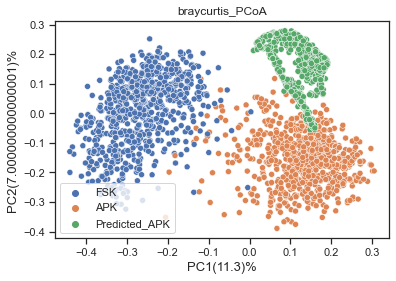

In [18]:
Predicted = autoencoder.predict(Microbiome_comparison_FSK_process)


def Only_trans(Predicted, Metadata, metric="braycurtis"):
    ####Tranformed only
    ID_prediction = Metadata[Metadata["Extraction.protocol"] == "FSK"]["Identifier"]
    Individual_ID_prediction = list(Metadata[Metadata["Extraction.protocol"] == "FSK"]["ID"])
    Protocol_prediction = list(pd.Series(["Predicted_APK"]).repeat(ID_prediction.shape[0]))
    Predicted[Predicted<0] = 0
    BC = beta_diversity(metric,Predicted)
    PCs = pcoa(BC)
    PC_values =  PCs.samples


    DF_PCA = pd.DataFrame( {'ID' : list(ID_prediction) , 'PC1' : list(PC_values.iloc[:,0]),
                          'PC2' : list(PC_values.iloc[:,1]), 'Protocol' : Protocol_prediction} ) 

    sns.set_theme(style="ticks")
    fig =plt.plot()
    sns.scatterplot(x="PC1", y="PC2", data=DF_PCA).set(title="BC-PCoA")


Data_save = Ordination(Predicted, Microbiome_comparison, Metadata, CLR = Do_CLR, Standar = False, metric="braycurtis")
print(Data_save.shape)
#Data_save.to_csv(path_or_buf="Data_Asier/Prediction_table_complete.tsv", sep='\t', header=True, index=False)
#print(Data_save)
#Only_trans(Predicted, Metadata)